![HELP-Logo](https://avatars1.githubusercontent.com/u/7880370?s=200&v=4)

# Exploring $z\sim5$ Lyman Break Galaxies in the HELP Virtual Observatory

In this notebook we use the HELP VO system to explore the properties of a sample of $z\sim5$ ($r$-dropouts) in the ELAIS-N1 data. Using the VO we search for $r$-dropout sources in the HyperSuprimeCam (HSC) data following the selection criteria applied by [Ono et al. (2017)](https://arxiv.org/abs/1704.06004).

For this sample of $z\sim5$ candidates we then explore their properties in the far-infrared using the HELP XID+ deconfused photometry measurements and make use of the HELP photometric redshift posteriors to construct a cleaner sample if IR-luminous LBG candidates.

This notebook assumes you have PyVO installed and working, if this is your first experience with using the HELP VO service you may consider starting with the other example notebooks to familiarise yourself with the steps.



In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pyvo as vo
from IPython import display

Here we define our main query, selecting all our columns of interest and joining the main datatable with the depth maps so that we only include sources from within the HSC optical footprint:

In [19]:
base_query="""
SELECT top 1000000
 t.help_id, t.hp_idx, t.ra, t.dec, t.redshift, t.zspec,
 t.m_ap_suprime_g, t.m_ap_suprime_r, t.m_ap_suprime_i, t.m_ap_suprime_z, t.m_ap_suprime_y,
 t.merr_ap_suprime_g, t.merr_ap_suprime_r, t.merr_ap_suprime_i, t.merr_ap_suprime_z, t.merr_ap_suprime_y,
 t.m_ap_irac_i1, t.merr_ap_irac_i1, t.m_ap_irac_i2, t.merr_ap_irac_i2,
 t.f_spire_250, t.f_spire_350, t.f_spire_500, 
 t.ferr_spire_250, t.ferr_spire_350, t.ferr_spire_500, 
 t.field, 
 t.cigale_sfr, t.cigale_dustlumin, t.cigale_mstar,
 t.cigale_sfr_err, t.cigale_dustlumin_err, t.cigale_mstar_err,
 c.ferr_suprime_z_mean, c.ferr_irac_i2_mean
FROM herschelhelp.main AS t
JOIN depth.main AS c
ON (t.field = 'ELAIS-N1') and t.hp_idx = c.hp_idx_o_13 and c.ferr_suprime_i_mean is NOT NULL
"""

Now we define the additional colour criteria that will be added to select the dropout candidates (`dropout_criteria`) or a small subset of the full catalog (`background_criteria`):

In [4]:
dropout_criteria = """
WHERE
    ((t.m_ap_suprime_r - t.m_ap_suprime_i) > 1.2) AND 
    ((t.m_ap_suprime_i - t.m_ap_suprime_z) < 0.7) AND 
    ((t.m_ap_suprime_r - t.m_ap_suprime_i) > (1.5*(t.m_ap_suprime_i - t.m_ap_suprime_z) + 1.1)) AND
    (abs(t.f_ap_suprime_g/t.ferr_ap_suprime_g) < 2) AND
    (abs(t.f_ap_suprime_z/t.ferr_ap_suprime_z) > 5) AND
    (abs(t.f_ap_suprime_y/t.ferr_ap_suprime_y) > 4)  
"""

background_criteria="""
WHERE
    t.hp_idx BETWEEN 188733368 AND 188763368
"""

#    ((abs(t.f_spire_250/t.ferr_spire_250) > 2) OR (abs(t.f_spire_350/t.ferr_spire_350) > 2) OR (abs(t.f_spire_500/t.ferr_spire_500) > 2))

Executing the queries and loading into astropy tables...

In [20]:
#Then we execute the query
service = vo.dal.TAPService("https://herschel-vos.phys.sussex.ac.uk/__system__/tap/run/tap")
result_set = service.search(base_query + dropout_criteria)
reference_set = service.search(base_query + background_criteria)

hsc_r_drops = result_set.to_table()
hsc_background = reference_set.to_table()

The forced photometry of XID+ may return many measurements that are consistent with zero, so we'll set our threshold for FIR detection as $2\sigma$ or more in at least two of the SPIRE bands.

In [21]:
fir_det = (((hsc_r_drops['f_spire_250']/hsc_r_drops['ferr_spire_250'] > 2.).astype('int') + 
           (hsc_r_drops['f_spire_350']/hsc_r_drops['ferr_spire_350'] > 2.).astype('int') +
           (hsc_r_drops['f_spire_500']/hsc_r_drops['ferr_spire_500'] > 2.).astype('int')) >= 2)

/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/numpy/ma/core.py:852: RuntimeWarning: invalid value encountered in absolute
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/numpy/ma/core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


## $r$-dropouts in ELAIS N1

Lets plots the candidates in the $r$-dropout colour space alongside our background subset of all galaxies to illustrate where everything lies.

(-1, 4)

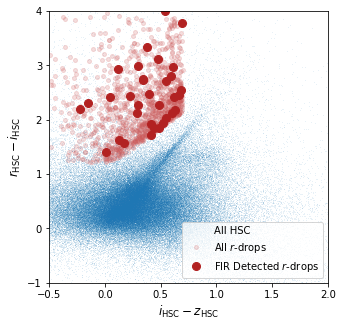

In [22]:
Fig, Ax = plt.subplots(1,1, figsize=(5,5))

Ax.plot(hsc_background['m_ap_suprime_i']-hsc_background['m_ap_suprime_z'], 
        hsc_background['m_ap_suprime_r']-hsc_background['m_ap_suprime_i'], ',', alpha=0.1, label='All HSC')

Ax.plot(hsc_r_drops['m_ap_suprime_i']-hsc_r_drops['m_ap_suprime_z'], 
        hsc_r_drops['m_ap_suprime_r']-hsc_r_drops['m_ap_suprime_i'], 
        'o', ms=4, color='indianred', alpha=0.2, label=r'All $r$-drops')

Ax.plot((hsc_r_drops['m_ap_suprime_i']-hsc_r_drops['m_ap_suprime_z'])[fir_det], 
        (hsc_r_drops['m_ap_suprime_r']-hsc_r_drops['m_ap_suprime_i'])[fir_det], 
        'o', ms=8, color='firebrick', label=r'FIR Detected $r$-drops')

Leg = Ax.legend(loc='lower right')

Ax.set_xlabel(r'$i_{\rm{HSC}} - z_{\rm{HSC}}$', size=12)
Ax.set_ylabel(r'$r_{\rm{HSC}} - i_{\rm{HSC}}$', size=12)
Ax.set_xlim([-0.5, 2])
Ax.set_ylim([-1, 4])

## What do the photometric redshift posteriors of our candidates look like?

Now we load the [HELP photo-$z$](https://github.com/H-E-L-P/dmu_products/tree/master/dmu24) posteriors to see the estimated redshifts for these candidates taking into account all of the available photometry (including additional near- and mid-infrared where available).

The posterior files are large but as they are HDF5 files, they do not need to be loaded into memory. Here we assume that the relevant file has been downloaded from [HeDAM](http://hedam.lam.fr/HELP/dataproducts/dmu24/) and is stored locally. We load in the posteriors for only our $z\sim5$ candidate sources.

In [23]:
pz_hdf = h5py.File('/Users/ken/pz_hb_en1.hdf', 'r') # Update to relevant local path
pz_help_id = pz_hdf['help_id'].value

matches = list(np.array([np.where(idx == pz_help_id) for idx in hsc_r_drops['help_id']]).squeeze())
hsc_r_drops_pz = np.array([pz_hdf['pz'][idx] for idx in matches])

For illustrative purposes, lets stack the posteriors (and re-normalise) for our different subsamples to see the overall redshift distributions.

In [24]:
pz_all = np.nansum(hsc_r_drops_pz, 0) # Sum all posteriors
pz_all /= np.trapz(pz_all, pz_hdf['zgrid']) # Re-normalise

pz_fir = np.nansum(hsc_r_drops_pz[fir_det], 0) # Sum SPIRE detected posteriors
pz_fir /= np.trapz(pz_fir, pz_hdf['zgrid']) # Re-normalise

Text(0,0.5,'$P(z)$')

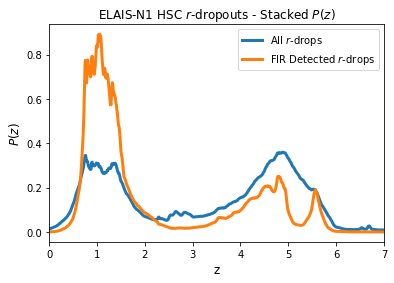

In [25]:
Fig, Ax = plt.subplots(1, 1, figsize=(6,4))
Ax.plot(pz_hdf['zgrid'], pz_all, lw=3, label=r'All $r$-drops')
Ax.plot(pz_hdf['zgrid'], pz_fir, lw=3, label=r'FIR Detected $r$-drops')

Leg = Ax.legend(loc='upper right')
Ax.set_xlim([0, 7])
Ax.set_title(r'ELAIS-N1 HSC $r$-dropouts - Stacked $P(z)$')
Ax.set_xlabel('z', size=12)
Ax.set_ylabel(r'$P(z)$', size=12)

As we can above, only approximately $\sim50\%$ of the sources are predicted to be at high redshift. This is consistent with the contamination estimates presented in [Ono et al. (2017)](https://arxiv.org/abs/1704.06004). As expected, the high redshift peak is centred at $z\sim5$ but has a very broad distribution.

The posterior distribution for the FIR detected sources is clearly different, with the majority being consistent with low redshift galaxies (i.e. mis-identification of the Balmer/Lyman break). There is still however clearly some candidates that are consistent with being at high redshift. Lets find out how many of the dropout sources have redshift posteriors consistent with the source being at $z > 3$

In [41]:
pz_gtr3 = (np.trapz(hsc_r_drops_pz[:,462:], pz_hdf['zgrid'][462:], axis=1) > 0.95)

/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


How many SPIRE detected sources remain after enforcing a stricter photo-$z$ requirement?

In [42]:
(pz_gtr3 * fir_det).sum()

4

Text(0,0.5,'$P(z)$')

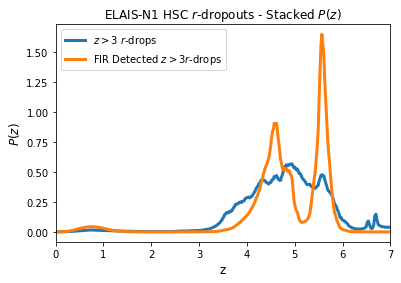

In [43]:
pz_stack_gtr3 = np.nansum(hsc_r_drops_pz[pz_gtr3], 0) # Sum all posteriors
pz_stack_gtr3 /= np.trapz(pz_stack_gtr3, pz_hdf['zgrid']) # Re-normalise

pz_fir_gtr3 = np.nansum(hsc_r_drops_pz[fir_det*pz_gtr3], 0) # Sum SPIRE detected posteriors
pz_fir_gtr3 /= np.trapz(pz_fir_gtr3, pz_hdf['zgrid']) # Re-normalise

Fig, Ax = plt.subplots(1, 1, figsize=(6,4))
Ax.plot(pz_hdf['zgrid'], pz_stack_gtr3, lw=3, label=r'$z > 3$ $r$-drops')
Ax.plot(pz_hdf['zgrid'], pz_fir_gtr3, lw=3, label=r'FIR Detected $z > 3 r$-drops')

Leg = Ax.legend(loc='upper left')
Ax.set_xlim([0, 7])
Ax.set_title(r'ELAIS-N1 HSC $r$-dropouts - Stacked $P(z)$')
Ax.set_xlabel('z', size=12)
Ax.set_ylabel(r'$P(z)$', size=12)

# Visual Inspection


In [58]:
hsc_r_drops[fir_det*pz_gtr3]

help_id,hp_idx,ra,dec,redshift,zspec,m_ap_suprime_g,m_ap_suprime_r,m_ap_suprime_i,m_ap_suprime_z,m_ap_suprime_y,merr_ap_suprime_g,merr_ap_suprime_r,merr_ap_suprime_i,merr_ap_suprime_z,merr_ap_suprime_y,m_ap_irac_i1,merr_ap_irac_i1,m_ap_irac_i2,merr_ap_irac_i2,f_spire_250,f_spire_350,f_spire_500,ferr_spire_250,ferr_spire_350,ferr_spire_500,field,cigale_sfr,cigale_dustlumin,cigale_mstar,cigale_sfr_err,cigale_dustlumin_err,cigale_mstar_err,ferr_suprime_z_mean,ferr_irac_i2_mean
,,deg,deg,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,uJy,uJy,uJy,uJy,uJy,uJy,,Msun / yr,W,Msun,Msun / yr,W,Msun,uJy,uJy
object,int64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64
HELP_J161743.484+543902.987,166309753,244.431183558057,54.650829766499299,4.6686001,--,29.114850000000001,24.76933,22.853698999999999,22.437823999999999,22.035988,2.1195624,0.072194079999999994,0.018267329999999998,0.021882276999999999,0.035690765999999999,20.267851660510399,0.026406696555626,20.406453644121601,0.046090523710196903,9921.3819999999996,10215.804,5362.3065999999999,1805.259,2175.924,2765.2613999999999,ELAIS-N1,1430.3847544324799,3.9800921350160101e+39,330903037993.51801,90.702139105647802,2.0752333104221501e+38,45033175967.108002,0.13585198000000001,2.4308661417322801
HELP_J161847.732+554248.369,166422561,244.69888331905699,55.7134359614993,5.6430998,--,26.901516000000001,41.946739999999998,22.2621,21.637653,21.103458,0.99654790000000004,550775.25,0.02145408,0.031116912,0.035820942000000001,19.507459413171802,0.0159583274190171,19.769142362343199,0.022483515262192399,13674.584999999999,15308.790000000001,6072.7624999999998,4283.2610000000004,4449.3019999999997,4991.5995000000003,ELAIS-N1,2689.4829033507999,5.7566311626709399e+39,481898491732.29498,230.018142553443,5.1331593416800703e+38,58188517943.909401,0.68124896000000001,1.3140993788819899
HELP_J161843.759+554214.534,166411615,244.682327406057,55.704037254499298,5.7767,--,38.316749999999999,38.793770000000002,21.888748,21.655754000000002,21.349276,36696.688000000002,30187.111000000001,0.014982575,0.030908519999999998,0.042985093000000002,19.720217468895999,0.0205684381063162,20.115957315530299,0.031277720884849598,12646.118,8568.0450000000001,10819.870000000001,2909.1570000000002,3262.4899999999998,4924.4179999999997,ELAIS-N1,2601.9759900700601,6.4843754998497703e+39,689985684819.448,225.64535355158799,3.7573670763251099e+38,107116115219.967,0.2412744,1.15818181818182
HELP_J160634.608+544111.999,166382126,241.64420055505701,54.686666292499297,4.3558002,--,28.710175,25.987568,24.369564,24.242664000000001,24.040087,1.2803929000000001,0.2070669,0.054099105000000001,0.10660395,0.21111060000000001,22.971990930726498,0.18578768285349001,22.898440875973101,0.227996337734093,11643.513999999999,15613.213,14544.67,1776.6479999999999,1212.2080000000001,700.64900000000102,ELAIS-N1,1320.91224557898,2.5473743349500602e+39,36784715156.152199,70.640448006059103,1.44994532155387e+38,7406474085.8990803,0.119166516,0.76026626032448996


In [29]:
url = 'https://hsc-release.mtk.nao.ac.jp/hscMap2'
iframe = '<iframe src=' + url + ' width=900 height=500></iframe>'
display.HTML(iframe)

 ![HELP LOGO](https://avatars1.githubusercontent.com/u/7880370?s=75&v=4)
 
**Author**: [Kenneth Duncan](http://dunkenj.github.io)

The Herschel Extragalactic Legacy Project, ([HELP](http://herschel.sussex.ac.uk/)), is a [European Commission Research Executive Agency](https://ec.europa.eu/info/departments/research-executive-agency_en)
funded project under the SP1-Cooperation, Collaborative project, Small or medium-scale focused research project, FP7-SPACE-2013-1 scheme, Grant Agreement
Number 607254.

[Acknowledgements](http://herschel.sussex.ac.uk/acknowledgements)
